#### 背景说明

对于企业来说，获得新客户的成本是非常高的，那么用户的留存分析就成了关键。每个客户的信息都是不一样的，很难找到其中的规律，但在客户数量足够多的情况下，可以使用数据挖掘算法进行分类预测，建立流失判别模型，对可能流失的用户进行重点关注。

#### 数据说明

数据为7043个电信用户的信息（数据已脱敏）,每行代表一个客户，每列包含了对应的客户属性，共21列。<br>

数据示例:<br>

|客户ID|性别|客户是否为老年人|客户是否有配偶|客户是否有家属|...|是否为电子计费|支付方式|每月消费|总消费|是否为流失|
|---|---|---|---|---|---|---|---|---|---|---|
|ID00001|女|0|是|1|...|是|支付宝|29.85|29.85|否|
|ID00002|男|0|否|34|...|否|微信|56.95|1889.50|否|
|ID00003|男|0|否|2|...|是|微信|53.85|108.15|是|
|ID00004|男|0|否|45|...|否|营业厅|42.30|1840.75|否|
|ID00005|女|0|否|2|...|是|支付宝|70.70|151.65|是|
|...|...|...|...|...|...|...|...|...|...|

客户是否为老年人：0表示不是，1表示是；<br>
客户留存时间：客户在公司停留的月数；

#### 分析思路
1.数据可视化。查看数据分布、统计特征，对部分特征进行可视化展示。<br>
2.分类模型搭建。使用随机森林模型进行流失分类，计算得分，预测测试集标签。<br>
3.特征重要性展示。查看特征重要性，进行特征重要性筛选，并绘图展示。

In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None) #显示所有列

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文
%matplotlib inline

import seaborn as sns 

import warnings
warnings.filterwarnings("ignore") #忽略警告

## 数据预处理

In [2]:
#数据读取

data = pd.read_csv('./电信用户流失数据.csv', encoding='utf-8') #读取csv数据，设置编码方式为utf-8
data.head(5) #查看前五行数据

,客户ID,性别,客户是否为老年人,客户是否有配偶,客户是否有家属,客户留存时间,客户是否有电话服务,客户是否多线路,客户的互联网服务提供商,客户是否具有在线安全性,客户是否联机备份,客户是否有设备保护,客户是否有技术支持,客户是否有电视服务,客户是否有电影服务,结算方式,是否为电子计费,支付方式,每月消费,总消费,是否为流失
0,ID00001,女,0,是,否,1,否,无电话服务,DSL,否,是,否,否,否,否,月结,是,支付宝,29.85,29.85,否
1,ID00002,男,0,否,否,34,是,否,DSL,是,否,是,否,否,否,年结,否,微信,56.95,1889.50,否
2,ID00003,男,0,否,否,2,是,否,DSL,是,是,否,否,否,否,月结,是,微信,53.85,108.15,是
3,ID00004,男,0,否,否,45,否,无电话服务,DSL,是,否,是,是,否,否,年结,否,营业厅,42.30,1840.75,否
4,ID00005,女,0,否,否,2,是,否,光纤,否,否,否,否,否,否,月结,是,支付宝,70.70,151.65,是


In [3]:
#检验缺失值

data.isnull().sum() #统计每个特征的缺失值个数

客户ID            0
性别              0
客户是否为老年人        0
客户是否有配偶         0
客户是否有家属         0
客户留存时间          0
客户是否有电话服务       0
客户是否多线路         0
客户的互联网服务提供商     0
客户是否具有在线安全性     0
客户是否联机备份        0
客户是否有设备保护       0
客户是否有技术支持       0
客户是否有电视服务       0
客户是否有电影服务       0
结算方式            0
是否为电子计费         0
支付方式            0
每月消费            0
总消费            11
是否为流失           0
dtype: int64

In [4]:
#清除缺失值

data = data.dropna() #删除缺失值所在行
data.isna().sum() #统计每个特征的缺失值个数

客户ID           0
性别             0
客户是否为老年人       0
客户是否有配偶        0
客户是否有家属        0
客户留存时间         0
客户是否有电话服务      0
客户是否多线路        0
客户的互联网服务提供商    0
客户是否具有在线安全性    0
客户是否联机备份       0
客户是否有设备保护      0
客户是否有技术支持      0
客户是否有电视服务      0
客户是否有电影服务      0
结算方式           0
是否为电子计费        0
支付方式           0
每月消费           0
总消费            0
是否为流失          0
dtype: int64

缺失值处理完成

In [5]:
#查看数据信息

data.info() #查看数据信息

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   客户ID         7032 non-null   object 
 1   性别           7032 non-null   object 
 2   客户是否为老年人     7032 non-null   int64  
 3   客户是否有配偶      7032 non-null   object 
 4   客户是否有家属      7032 non-null   object 
 5   客户留存时间       7032 non-null   int64  
 6   客户是否有电话服务    7032 non-null   object 
 7   客户是否多线路      7032 non-null   object 
 8   客户的互联网服务提供商  7032 non-null   object 
 9   客户是否具有在线安全性  7032 non-null   object 
 10  客户是否联机备份     7032 non-null   object 
 11  客户是否有设备保护    7032 non-null   object 
 12  客户是否有技术支持    7032 non-null   object 
 13  客户是否有电视服务    7032 non-null   object 
 14  客户是否有电影服务    7032 non-null   object 
 15  结算方式         7032 non-null   object 
 16  是否为电子计费      7032 non-null   object 
 17  支付方式         7032 non-null   object 
 18  每月消费         7032 non-null   float64
 19  总消费   

“客户是否为老年人”应该是分类特征

In [6]:
#特征类型转换

data['客户是否为老年人'] = data['客户是否为老年人'].astype('str') #转为字符型
data.info() #查看数据信息

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   客户ID         7032 non-null   object 
 1   性别           7032 non-null   object 
 2   客户是否为老年人     7032 non-null   object 
 3   客户是否有配偶      7032 non-null   object 
 4   客户是否有家属      7032 non-null   object 
 5   客户留存时间       7032 non-null   int64  
 6   客户是否有电话服务    7032 non-null   object 
 7   客户是否多线路      7032 non-null   object 
 8   客户的互联网服务提供商  7032 non-null   object 
 9   客户是否具有在线安全性  7032 non-null   object 
 10  客户是否联机备份     7032 non-null   object 
 11  客户是否有设备保护    7032 non-null   object 
 12  客户是否有技术支持    7032 non-null   object 
 13  客户是否有电视服务    7032 non-null   object 
 14  客户是否有电影服务    7032 non-null   object 
 15  结算方式         7032 non-null   object 
 16  是否为电子计费      7032 non-null   object 
 17  支付方式         7032 non-null   object 
 18  每月消费         7032 non-null   float64
 19  总消费   

In [7]:
#查看数据统计量信息

data.describe() #查看数据统计量

,客户留存时间,每月消费,总消费
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


客户留存时间、每月消费、总消费三列是数值型。

In [8]:
#查看特征名和特征个数

print('列名：\n', data.columns.values) #列名
print(' '*20)
print('特征个数：', len(data.columns)-1) #特征个数

列名：
 ['客户ID' '性别' '客户是否为老年人' '客户是否有配偶' '客户是否有家属' '客户留存时间' '客户是否有电话服务' '客户是否多线路'
 '客户的互联网服务提供商' '客户是否具有在线安全性' '客户是否联机备份' '客户是否有设备保护' '客户是否有技术支持'
 '客户是否有电视服务' '客户是否有电影服务' '结算方式' '是否为电子计费' '支付方式' '每月消费' '总消费' '是否为流失']
                    
特征个数： 20


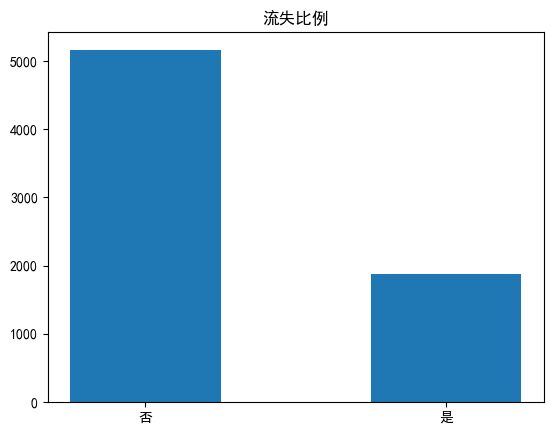

In [9]:
#绘制直方图查看流失

fig = plt.figure() #画布

loss = data.groupby('是否为流失')['客户ID'].count() #对流失进行分组聚合，计算流失与未流失人数
label = ['否','是'] #标签
plt.bar(label,loss,width=0.5) #绘制柱状图，宽度为0.5
plt.title('流失比例') #标题
plt.show()

In [10]:
#计算流失比例

data['是否为流失'].value_counts(normalize=True) #统计流失与未流失个数，显示为频率

否    0.734215
是    0.265785
Name: 是否为流失, dtype: float64

准确率必须超过73.4%，否则模型没有意义

## 数值型特征

In [11]:
#数值型特征的客户对比

data_churn = data[data['是否为流失']=='是'] #流失
data_retention = data[data['是否为流失']=='否'] #未流失

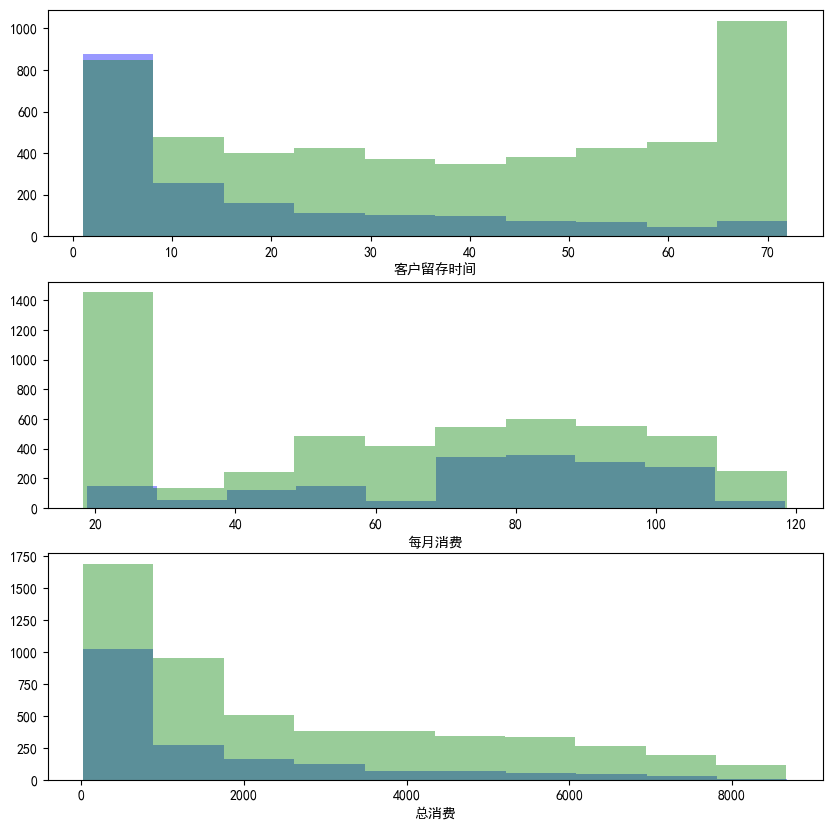

In [12]:
#三个数值特征可视化

fig = plt.figure(figsize=(10,10)) #设置图像大小

#客户留存时间对比
ax1 = fig.add_subplot(3,1,1) #子图1
sns.distplot(data_churn['客户留存时间'],bins=10,hist=True,kde=False,color='b') #流失客户直方图，箱数设为10，不绘制核密度图，颜色为蓝色
sns.distplot(data_retention['客户留存时间'],bins=10,hist=True,kde=False,color='g') #未流失客户直方图，箱数设为10，不绘制核密度图，颜色为绿色

#客户每月消费对比
ax2 = fig.add_subplot(3,1,2)#子图2
sns.distplot(data_churn['每月消费'],bins=10,hist=True,kde=False,color='b') #流失客户直方图，箱数设为10，不绘制核密度图，颜色为蓝色
sns.distplot(data_retention['每月消费'],bins=10,hist=True,kde=False,color='g') #未流失客户直方图，箱数设为10，不绘制核密度图，颜色为绿色

#客户总消费对比
ax3 = fig.add_subplot(3,1,3)#子图3
sns.distplot(data_churn['总消费'],bins=10,hist=True,kde=False,color='b') #流失客户直方图，箱数设为10，不绘制核密度图，颜色为蓝色
sns.distplot(data_retention['总消费'],bins=10,hist=True,kde=False,color='g') #未流失客户直方图，箱数设为10，不绘制核密度图，颜色为绿色

plt.subplots_adjust(wspace=0.1) #子图水平距离
plt.show()

客户留存时间越长，越不容易流失；每月消费20到30月的客户很多，客户是否流失与消费金额关系不大。

## 分类特征

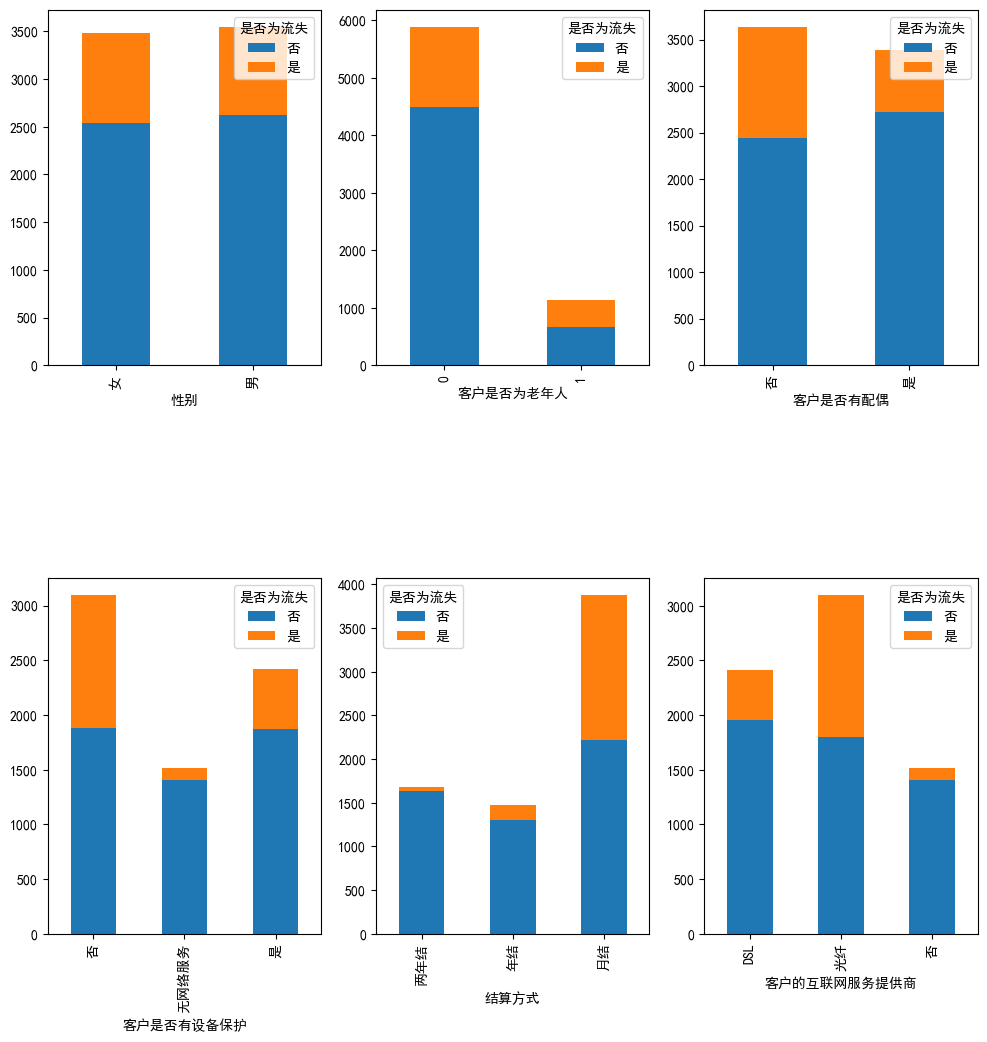

In [13]:
#分类特征很多，只选取其中6个特征作查看

fig,axes = plt.subplots(2,3,figsize=(12,12)) #设置图像大小、子图排列方式，两行三列
axe=axes.ravel() #axes中解压所有子图数组
 
#流失与性别的关系
data0 = data.groupby(['性别','是否为流失'])['是否为流失'].count().unstack() #对性别和流失进行分组统计，计算性别，行转列
data0.plot(kind='bar',ax = axe[0],stacked='True') #绘制柱状图，位置是第一个子图，进行堆叠

#流失与老年人的关系  
data1 = data.groupby(['客户是否为老年人','是否为流失'])['是否为流失'].count().unstack()  #对性别和客户是否为老年人进行分组统计，计算性别，行转列
data1.plot(kind='bar',ax = axe[1],stacked='True') #绘制柱状图，位置是第二个子图，进行堆叠

#流失与是否有配偶的关系
data2 = data.groupby(['客户是否有配偶','是否为流失'])['是否为流失'].count().unstack()  #对性别和客户是否有配偶进行分组统计，计算性别，行转列
data2.plot(kind='bar',ax = axe[2],stacked='True') #绘制柱状图，位置是第三个子图，进行堆叠

#流失与是否有设备保护的关系
data3 = data.groupby(['客户是否有设备保护','是否为流失'])['是否为流失'].count().unstack() #对性别和客户是否有设备保护进行分组统计，计算性别，行转列
data3.plot(kind='bar',ax = axe[3],stacked='True') #绘制柱状图，位置是第四个子图，进行堆叠

#流失与结算方式的关系
data4 = data.groupby(['结算方式','是否为流失'])['是否为流失'].count().unstack() #对性别和结算方式进行分组统计，计算性别，行转列
data4.plot(kind='bar',ax = axe[4],stacked='True') #绘制柱状图，位置是第五个子图，进行堆叠

#流失与客户的互联网服务提供商的关系
data5 = data.groupby(['客户的互联网服务提供商','是否为流失'])['是否为流失'].count().unstack() #对性别和客户的互联网服务提供商进行分组统计，计算性别，行转列
data5.plot(kind='bar',ax = axe[5],stacked='True') #绘制柱状图，位置是第六个子图，进行堆叠


plt.subplots_adjust(hspace=0.6) #子图竖直距离
plt.show()

性别与流失的关系不大；老年人更容易流失；没有配偶更容易流失；月结客户更容易流失；使用光纤的客户更容易流失

## 拆分特征和标签

In [14]:
#特征
#特征是第二列至倒数第二列

x = data.iloc[:,1:-1] #特征。按行列索引，取所有行、第二列至倒数第二列
x[:5]

,性别,客户是否为老年人,客户是否有配偶,客户是否有家属,客户留存时间,客户是否有电话服务,客户是否多线路,客户的互联网服务提供商,客户是否具有在线安全性,客户是否联机备份,客户是否有设备保护,客户是否有技术支持,客户是否有电视服务,客户是否有电影服务,结算方式,是否为电子计费,支付方式,每月消费,总消费
0,女,0,是,否,1,否,无电话服务,DSL,否,是,否,否,否,否,月结,是,支付宝,29.85,29.85
1,男,0,否,否,34,是,否,DSL,是,否,是,否,否,否,年结,否,微信,56.95,1889.50
2,男,0,否,否,2,是,否,DSL,是,是,否,否,否,否,月结,是,微信,53.85,108.15
3,男,0,否,否,45,否,无电话服务,DSL,是,否,是,是,否,否,年结,否,营业厅,42.30,1840.75
4,女,0,否,否,2,是,否,光纤,否,否,否,否,否,否,月结,是,支付宝,70.70,151.65


In [15]:
#标签
#最后一列为标签

y = data['是否为流失'] #标签。取最后一列，标签列
y[:5]

0    否
1    否
2    是
3    否
4    是
Name: 是否为流失, dtype: object

## 分割数据集

In [16]:
#分割数据集


from sklearn.model_selection import train_test_split
#将数据分割为训练集，测试集，训练集标签，测试集标签
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=42) #测试集占比20%，设置随机种子为42

## 特征编码

In [17]:
#特征编码。分别对训练集测试集编码，防止数据泄露
#DictVectorizer进行独热编码时，不会将数值型编码，而是保留

from sklearn.preprocessing import LabelEncoder #标签编码器
from sklearn.feature_extraction import DictVectorizer #独热编码器

dv = DictVectorizer() #独热编码
le = LabelEncoder() #标签编码

dv_fit  = dv.fit(X_train.to_dict(orient='records')) #转为dict，训练
le_fit = le.fit(y_train) #训练

X_train = dv_fit.transform(X_train.to_dict(orient='records')) #训练集转换
X_test = dv_fit.transform(X_test.to_dict(orient='records')) #测试集转换

y_train = le_fit.transform(y_train) #训练集转换
y_test = le_fit.transform(y_test) #测试集转换


In [18]:
#查看特征

dv.feature_names_ #获取特征名称

['客户是否为老年人=0',
 '客户是否为老年人=1',
 '客户是否具有在线安全性=否',
 '客户是否具有在线安全性=无网络服务',
 '客户是否具有在线安全性=是',
 '客户是否多线路=否',
 '客户是否多线路=无电话服务',
 '客户是否多线路=是',
 '客户是否有家属=否',
 '客户是否有家属=是',
 '客户是否有技术支持=否',
 '客户是否有技术支持=无网络服务',
 '客户是否有技术支持=是',
 '客户是否有电影服务=否',
 '客户是否有电影服务=无网络服务',
 '客户是否有电影服务=是',
 '客户是否有电视服务=否',
 '客户是否有电视服务=无网络服务',
 '客户是否有电视服务=是',
 '客户是否有电话服务=否',
 '客户是否有电话服务=是',
 '客户是否有设备保护=否',
 '客户是否有设备保护=无网络服务',
 '客户是否有设备保护=是',
 '客户是否有配偶=否',
 '客户是否有配偶=是',
 '客户是否联机备份=否',
 '客户是否联机备份=无网络服务',
 '客户是否联机备份=是',
 '客户留存时间',
 '客户的互联网服务提供商=DSL',
 '客户的互联网服务提供商=光纤',
 '客户的互联网服务提供商=否',
 '性别=女',
 '性别=男',
 '总消费',
 '支付方式=app',
 '支付方式=微信',
 '支付方式=支付宝',
 '支付方式=营业厅',
 '是否为电子计费=否',
 '是否为电子计费=是',
 '每月消费',
 '结算方式=两年结',
 '结算方式=年结',
 '结算方式=月结']

## 随机森林分类算法

In [19]:
#随机森林分类

from sklearn.ensemble import RandomForestClassifier
#随机森林分类器
clf = RandomForestClassifier(
                            min_samples_leaf=20, #每个节点的最小样本数
                            max_depth=10, #最大树深
                            n_estimators=150, #弱分类器的个数
                            random_state=42 #随机种子固定
                            )
clf.fit(X_train,y_train) #训练分类器

RandomForestClassifier(max_depth=10, min_samples_leaf=20, n_estimators=150,
                       random_state=42)

In [20]:
#准确率

print("训练集准确率：",clf.score(X_train,y_train)) #训练集准确率
print("测试集准确率：",clf.score(X_test,y_test))   #测试集准确率

训练集准确率： 0.8227555555555556
测试集准确率： 0.7889125799573561


In [21]:
#预测

y_pred = clf.predict(X_test) #预测测试集标签
y_pred

array([0, 0, 1, ..., 0, 0, 0])

真实值： Counter({0: 1033, 1: 374})
预测值： Counter({0: 1140, 1: 267})
总体准确率： 0.7889


<AxesSubplot:>

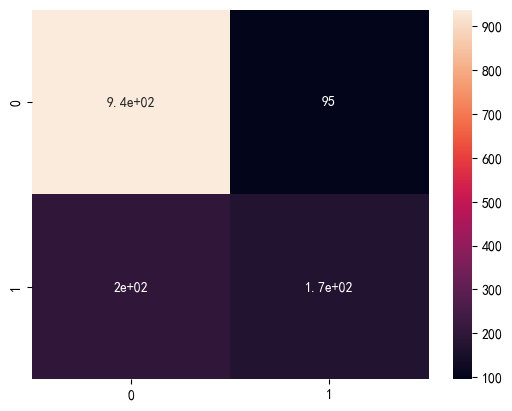

In [22]:
#混淆矩阵

from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix


print("真实值：",Counter(y_test)) #真实标签
print("预测值：",Counter(y_pred)) #预测标签
print ("总体准确率：",round(sum(y_test==y_pred) / len(y_test),4)) #计算准确率

confmat= confusion_matrix(y_true=y_test,y_pred=y_pred) #输出混淆矩阵
sns.heatmap(confmat,annot=True) #绘制热度图

In [23]:
#模型报告

from sklearn.metrics import classification_report

print(classification_report(y_pred,y_test,target_names=['否','|是'])) #输出模型评估报告

              precision    recall  f1-score   support

           否       0.91      0.82      0.86      1140
          |是       0.46      0.64      0.54       267

    accuracy                           0.79      1407
   macro avg       0.68      0.73      0.70      1407
weighted avg       0.82      0.79      0.80      1407



## 查看特征重要性

In [25]:
#特征排序

importance = clf.feature_importances_ #特征重要性
indices = np.argsort(importance) #获取排序索引
#indices
importance_sort = clf.feature_importances_[indices] #特征重要性按索引排序
feature_names_sort = np.array(dv.feature_names_)[indices] #特征名转化为array格式后排序

#list(zip(importance_sort,feature_names_sort))

In [26]:
#特征筛选

importance_select = [] #特征重要性
feature_select = [] #特征名

#获取筛选后的特征名和特征重要性
for i,j in list(zip(importance_sort,feature_names_sort)): 
    #特征重要性是否大于0.01
    if i>0.01:  
        importance_select.append(i) #添加到importance_select中
        feature_select.append(j) #添加到feature_select中
    else:
        continue

In [28]:
# 打印特征及重要性值
for num,name in zip(importance_select, feature_select):
    if name == '结算方式=月结':
        print(f"{name}\t{num}")
    elif name == '客户留存时间':
        print(f"{name}\t{num}")

客户留存时间	0.13737545629372408
结算方式=月结	0.1439376133408773


In [ ]:
#特征可视化

y_pos = np.arange(len(feature_select)) #特征个数的排列

fig = plt.figure(figsize=(12,12)) #设置图像大小
plt.barh(y_pos, importance_select, align='center') #条形图
plt.yticks(y_pos, feature_select) #y轴刻度
plt.xlabel('特征') #x轴标签
plt.xlim(0,1) #x轴坐标范围
plt.title('特征重要性') #标题
plt.show()
